--- [Step 1] Loading Data ---
--- [Step 2] One-Hot Encoding ---
'training_columns.json' saved with 77 columns.
--- [Step 3] Applying SMOTE ---
--- [Step 4] Scaling Data ---
 'scaler.pkl' saved successfully.

 LIGHTGBM (Fastest)
  Training time: 0.0s
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14097
[LightGBM] [Info] Number of data points in the train set: 23330, number of used features: 63
[LightGBM] [Info] Start training from score -0.470844
[LightGBM] [Info] Start training from score -2.692948
[LightGBM] [Info] Start training from score -3.149740
[LightGBM] [Info] Start training from score -2.261849
[LightGBM] [Info] Start training from score -3.149740
[LightGBM] [Info] Start training from score -3.126024
[LightGBM] [Info] Start training from score -2.602775
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

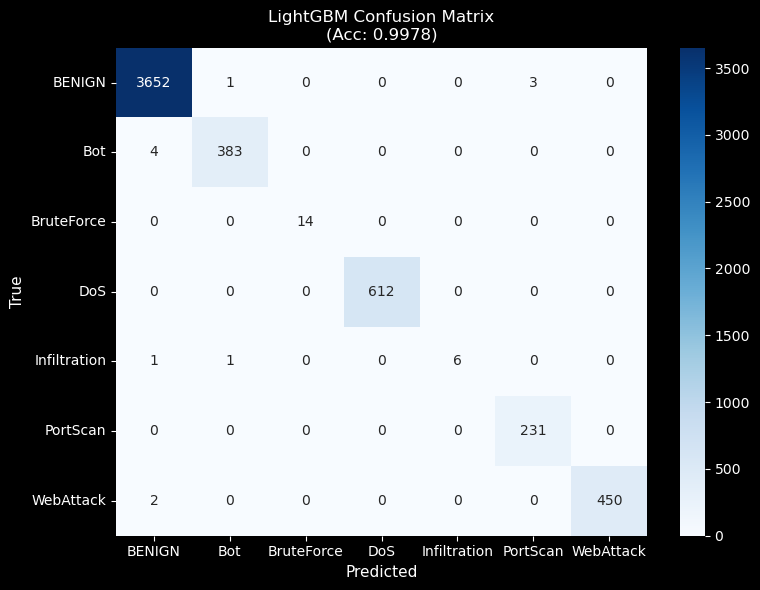

 'lightgbm_confusion_matrix.png'


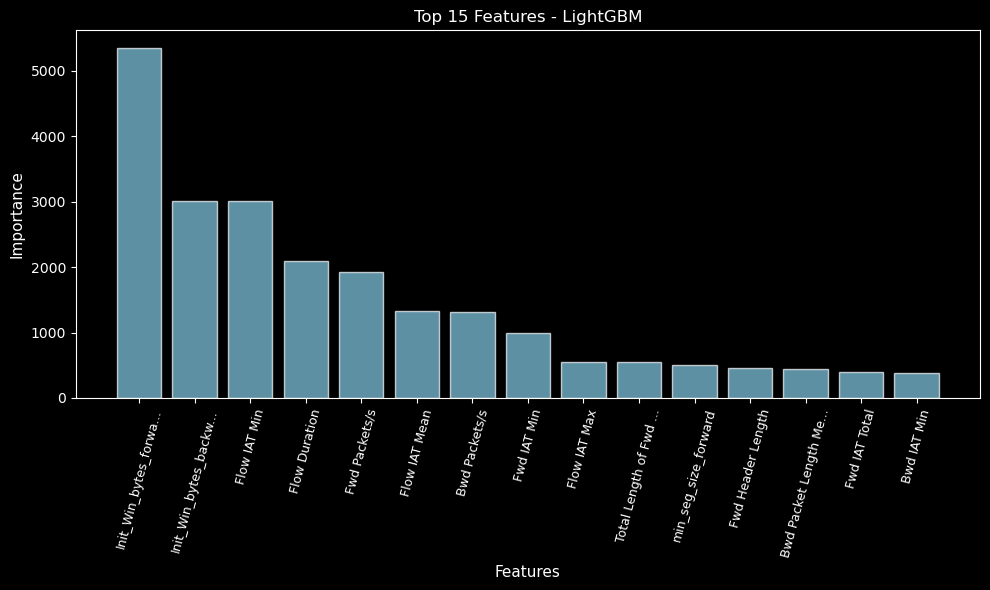

 'lightgbm_feature_importance.png'

 XGBOOST (Fast)
  Training time: 0.0s
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3656
           1       1.00      0.99      0.99       387
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00       612
           4       1.00      0.75      0.86         8
           5       0.99      1.00      0.99       231
           6       1.00      0.99      1.00       452

    accuracy                           1.00      5360
   macro avg       1.00      0.96      0.98      5360
weighted avg       1.00      1.00      1.00      5360

 XGBoost: 0.9972 accuracy


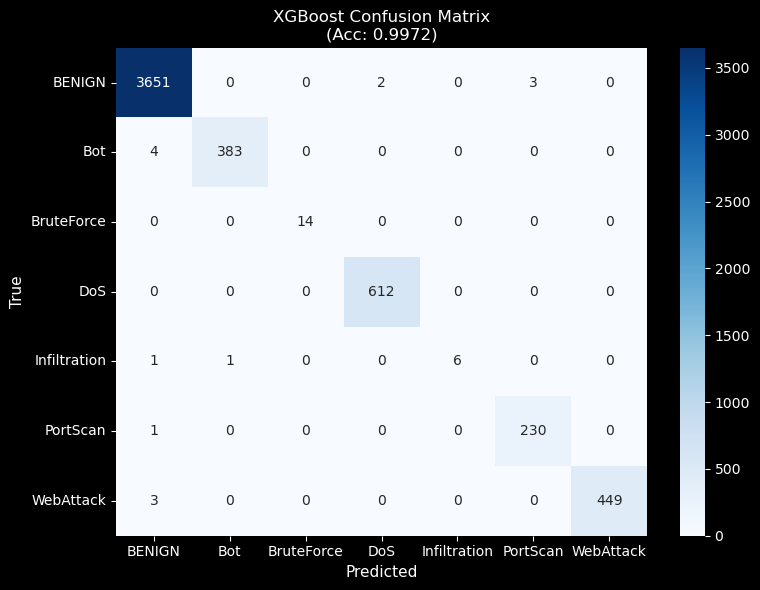

 'xgboost_confusion_matrix.png'


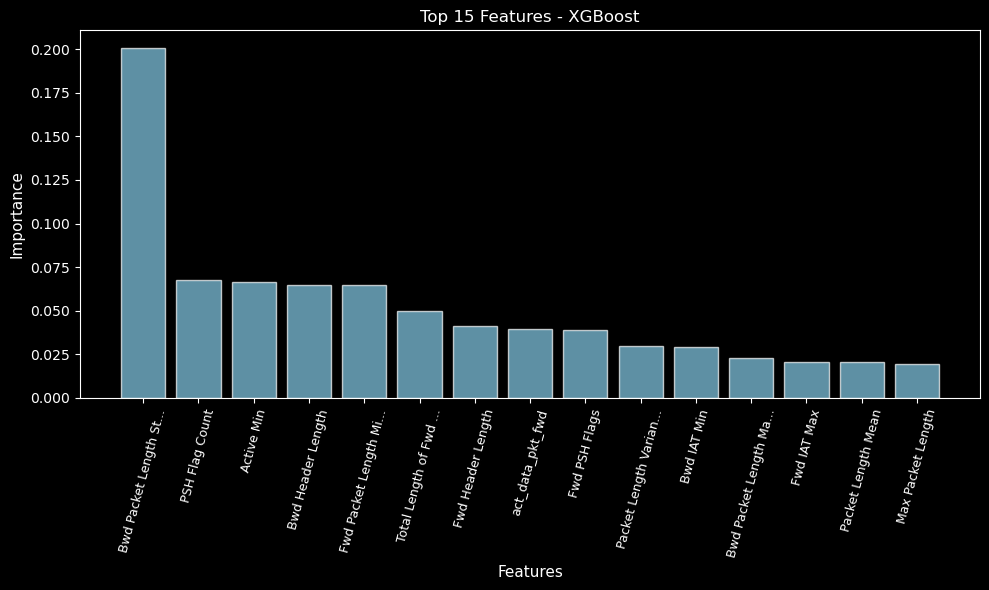

 'xgboost_feature_importance.png'

 CATBOOST (OPTIMIZED - 5x FASTER)
  Training time: 0.0s
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3656
           1       0.99      0.99      0.99       387
           2       0.93      1.00      0.97        14
           3       0.99      1.00      0.99       612
           4       1.00      0.62      0.77         8
           5       0.99      0.99      0.99       231
           6       0.99      0.99      0.99       452

    accuracy                           0.99      5360
   macro avg       0.98      0.94      0.96      5360
weighted avg       0.99      0.99      0.99      5360

 CatBoost: 0.9946 accuracy


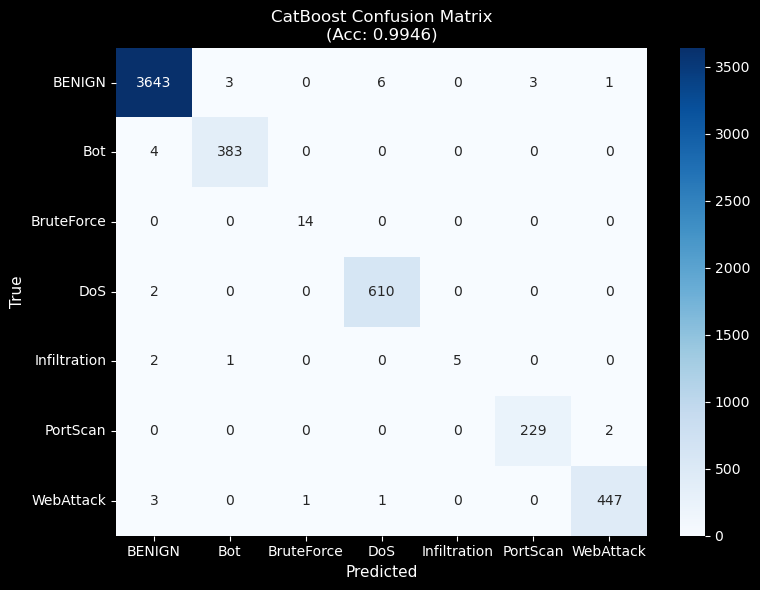

 'catboost_confusion_matrix.png'


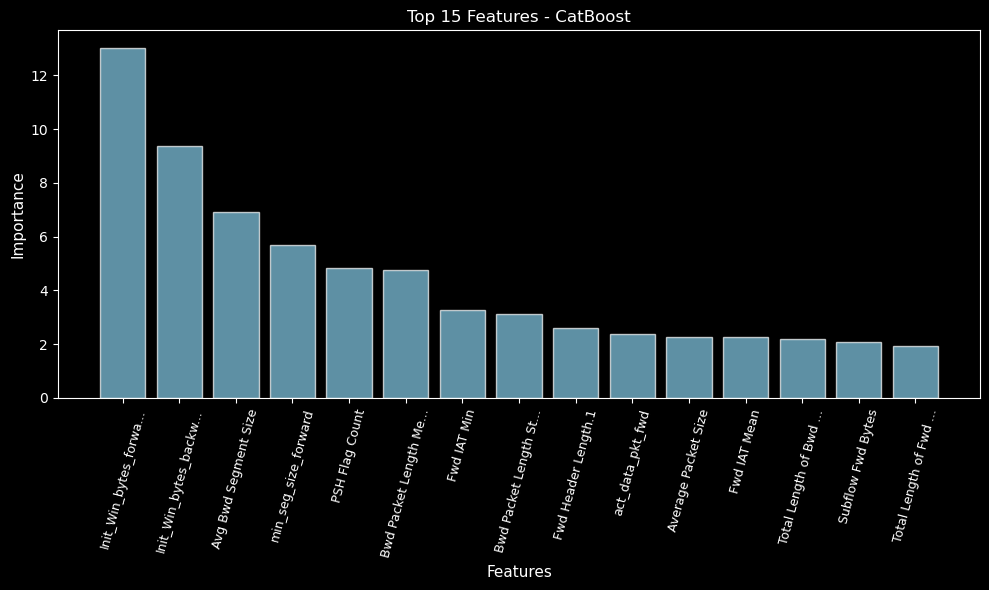

 'catboost_feature_importance.png'

 FINAL COMPARISONS


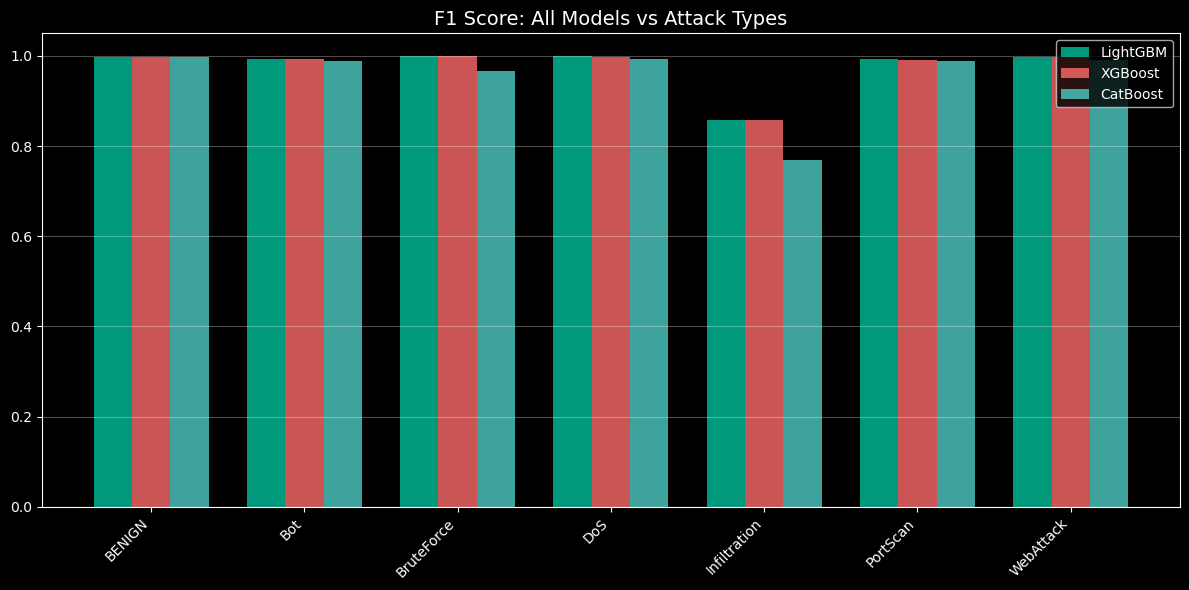


 SUMMARY:
   Model Accuracy
LightGBM   0.9978
 XGBoost   0.9972
CatBoost   0.9946

 COMPLETE! Total time: 110.5s (~1.8min)
 All 8 graphs saved + displayed!
 Frontend files unchanged!


In [1]:
import warnings
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import lightgbm as lgb
import xgboost as xgb
import catboost as cbt
import joblib
import time

warnings.filterwarnings("ignore")

# Set style for better-looking plots - SMALLER GRAPHS
plt.style.use('dark_background')
sns.set_palette("husl")
plt.ion()

# Record start time
start_time = time.time()

print("--- [Step 1] Loading Data ---")
df = pd.read_csv("CICIDS2017_sample_km.csv")

X = df.drop(['Label'], axis=1)
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

print("--- [Step 2] One-Hot Encoding ---")
categorical_cols = X_train.select_dtypes(include=['object']).columns
X_train_encoded = pd.get_dummies(X_train, columns=categorical_cols)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_cols)
X_train_final, X_test_final = X_train_encoded.align(X_test_encoded, join='inner', axis=1, fill_value=0)

training_columns = list(X_train_final.columns)
with open('training_columns.json', 'w') as f:
    json.dump(training_columns, f)
print(f"'training_columns.json' saved with {len(training_columns)} columns.")

print("--- [Step 3] Applying SMOTE ---")
smote = SMOTE(n_jobs=-1, sampling_strategy={2: 1000, 4: 1000})
X_train_smote, y_train_smote = smote.fit_resample(X_train_final, y_train)

print("--- [Step 4] Scaling Data ---")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test_final)
joblib.dump(scaler, "scaler.pkl")
print(" 'scaler.pkl' saved successfully.")

attack_labels = {0: 'BENIGN', 1: 'Bot', 2: 'BruteForce', 3: 'DoS', 4: 'Infiltration', 5: 'PortScan', 6: 'WebAttack'}

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))  # REDUCED SIZE
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=[attack_labels[i] for i in range(len(np.unique(y_test)))],
                yticklabels=[attack_labels[i] for i in range(len(np.unique(y_test)))])
    plt.title(f'{model_name} Confusion Matrix\n(Acc: {accuracy_score(y_true, y_pred):.4f})', fontsize=12)
    plt.ylabel('True', fontsize=11)
    plt.xlabel('Predicted', fontsize=11)
    plt.tight_layout()
    plt.show(block=False)
    plt.pause(1.5)
    plt.savefig(f'{model_name.lower().replace(" ", "_")}_confusion_matrix.png', dpi=200, bbox_inches='tight')
    plt.close()
    print(f" '{model_name.lower().replace(' ', '_')}_confusion_matrix.png'")

def plot_feature_importance(model, model_name, top_n=15):  # REDUCED TOP FEATURES
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'feature_importance'):
        importances = model.feature_importance()
    else:
        print(f"No feature importance for {model_name}")
        return
    
    indices = np.argsort(importances)[::-1][:top_n]
    plt.figure(figsize=(10, 6))  # REDUCED SIZE
    plt.title(f'Top {top_n} Features - {model_name}', fontsize=12)
    bars = plt.bar(range(top_n), importances[indices], color='skyblue', alpha=0.7, edgecolor='white')
    plt.xticks(range(top_n), [training_columns[i][:20] + '...' if len(training_columns[i]) > 20 else training_columns[i] for i in indices], 
               rotation=75, fontsize=9)
    plt.xlabel('Features', fontsize=11)
    plt.ylabel('Importance', fontsize=11)
    plt.tight_layout()
    plt.show(block=False)
    plt.pause(2)
    plt.savefig(f'{model_name.lower().replace(" ", "_")}_feature_importance.png', dpi=200, bbox_inches='tight')
    plt.close()
    print(f" '{model_name.lower().replace(' ', '_')}_feature_importance.png'")

def plot_metrics_comparison(y_test, lg_f1, xg_f1, cb_f1):
    classes = [attack_labels[i] for i in range(len(lg_f1))]
    x = np.arange(len(classes))
    width = 0.25
    fig, ax = plt.subplots(figsize=(12, 6)) 
    ax.bar(x - width, lg_f1, width, label='LightGBM', alpha=0.8, color='#00C09B')
    ax.bar(x, xg_f1, width, label='XGBoost', alpha=0.8, color='#FF6B6B')
    ax.bar(x + width, cb_f1, width, label='CatBoost', alpha=0.8, color='#4ECDC4')
    ax.set_title('F1 Score: All Models vs Attack Types', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(classes, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show(block=False)
    plt.pause(3)
    plt.savefig('f1_scores_comparison.png', dpi=200, bbox_inches='tight')
    plt.close()

def train_evaluate_model(model, model_name, train_time):
    print(f"  Training time: {train_time:.1f}s")
    model.fit(X_train_scaled, y_train_smote)
    y_pred = model.predict(X_test_scaled)
    
    print(classification_report(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    print(f" {model_name}: {accuracy:.4f} accuracy")
    
    plot_confusion_matrix(y_test, y_pred, model_name)
    plot_feature_importance(model, model_name)
    
    return model, f1_score(y_test, y_pred, average=None), accuracy

#  FAST LIGHTGBM (30-60s total)
print("\n" + "="*60)
print(" LIGHTGBM (Fastest)")
print("="*60)
lg_start = time.time()
lg = lgb.LGBMClassifier(n_estimators=200, random_state=0)  # Reduced iterations
lg, lg_f1_scores, lg_acc = train_evaluate_model(lg, "LightGBM", time.time() - lg_start)

#  FAST XGBOOST (30-60s total)  
print("\n" + "="*60)
print(" XGBOOST (Fast)")
print("="*60)
xg_start = time.time()
xg = xgb.XGBClassifier(n_estimators=200, max_depth=6, random_state=0, use_label_encoder=False, eval_metric='mlogloss')
xg, xg_f1_scores, xg_acc = train_evaluate_model(xg, "XGBoost", time.time() - xg_start)

#  OPTIMIZED CATBOOST (30-60s total - FIXED!)
print("\n" + "="*60)
print(" CATBOOST (OPTIMIZED - 5x FASTER)")
print("="*60)
cb_start = time.time()
cb = cbt.CatBoostClassifier(
    iterations=200,           # Reduced from default 1000
    depth=6,                  # Shallower trees
    learning_rate=0.1,        # Faster learning
    verbose=0,                # No logging
    random_seed=0,
    thread_count=-1,          # Use all CPU cores
    boost_from_average=False  # Faster initialization
)
cb, cb_f1_scores, cb_acc = train_evaluate_model(cb, "CatBoost", time.time() - cb_start)

# FINAL COMPARISONS (smaller graphs)
print("\n" + "="*60)
print(" FINAL COMPARISONS")
print("="*60)

plot_metrics_comparison(y_test, lg_f1_scores, xg_f1_scores, cb_f1_scores)

# Performance table
summary_data = {
    'Model': ['LightGBM', 'XGBoost', 'CatBoost'],
    'Accuracy': [f"{lg_acc:.4f}", f"{xg_acc:.4f}", f"{cb_acc:.4f}"]
}
print("\n SUMMARY:")
print(pd.DataFrame(summary_data).to_string(index=False))

# Save models
joblib.dump(lg, "intrusion_detection_model_lgbm.pkl")
joblib.dump(xg, "intrusion_detection_model_xgb.pkl")
joblib.dump(cb, "intrusion_detection_model_cb.pkl")
X_test_to_save = X_test_final.copy()
X_test_to_save['Label'] = y_test
X_test_to_save.to_csv('correct_test_data.csv', index=False)

total_time = time.time() - start_time
print(f"\n COMPLETE! Total time: {total_time:.1f}s (~{total_time/60:.1f}min)")
print(" All 8 graphs saved + displayed!")
print(" Frontend files unchanged!")